# Dependências

In [0]:
!pip install tensorflow-gpu==2.0.0-alpha0

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.datasets.samples_generator import make_blobs, make_circles, make_moons, make_classification, make_regression
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

%matplotlib inline

print(tf.__version__)

2.0.0-alpha0


In [0]:
#@title
def plot_random_batch(batch, y_true, y_pred=None, batch_size=30, n_cols=10, figsize=(20, 10)):
    plt.figure(figsize=figsize)

    random_idx = np.random.choice(batch.shape[0], size=batch_size)
    x_batch = batch[random_idx].squeeze()
    y_batch = y_true[random_idx]
    
    y_pred = y_batch if y_pred is None else y_pred[random_idx]
    n_rows = x_batch.shape[0] // n_cols + 1
    is_gray = (batch.shape[-1] == 1 or batch.ndim == 3)
    for img, true, pred, sub in zip(x_batch, y_batch, y_pred, range(1, len(batch)+1)):
        plt.subplot(n_rows, n_cols, sub)
        plt.imshow(img.astype(np.uint8), cmap='gray' if is_gray else None)
        
        plt.title("T:{} P:{}".format(true, pred), color = 'green' if true == pred else 'red')
        plt.axis('off')
    plt.tight_layout()
    
def make_cubic(n_samples, x_min, x_max, a=1, b=0, c=0, d=0, noise=0.0, random_state=None):
    np.random.seed(random_state)
    x = np.linspace(x_min, x_max, n_samples)
    y = a*x**3 + b*x**2 + c*x + d + (2*noise*np.random.random(n_samples) - noise)
    return x.reshape(-1,1), y.reshape(-1,1)

def make_exp(n_samples, x_min, x_max, noise=0.0, random_state=None):
    np.random.seed(random_state)
    x = np.linspace(x_min, x_max, n_samples)
    y = np.exp(x) + 2*noise*np.random.random(n_samples) - noise
    return x.reshape(-1,1), y.reshape(-1,1)
    
def make_log10(n_samples, x_min, x_max, noise=0.0, random_state=None):
    np.random.seed(random_state)
    x = np.logspace(np.log10(x_min), np.log10(x_max), n_samples)
    y = np.log10(x) + 2*noise*np.random.random(n_samples) - noise
    return x.reshape(-1,1), y.reshape(-1,1)

def make_square(n_samples, x_min, x_max, a=1, b=0, c=0, noise=0.0, random_state=None):
    np.random.seed(random_state)
    x = np.linspace(x_min, x_max, n_samples)
    y = a*x**2 + b*x + c + (2*noise*np.random.random(n_samples) - noise)
    return x.reshape(-1,1), y.reshape(-1,1)
    
def make_spiral(n_samples, n_class=2, radius=1, laps=1.0, noise=0.0, random_state=None):
    np.random.seed(random_state)
    x = np.zeros((n_samples * n_class, 2))
    y = np.zeros((n_samples * n_class))
    
    pi_2 = 2 * np.math.pi
    points = np.linspace(0, 1, n_samples)
    r = points * radius
    t = points * pi_2 * laps
    for label, delta_t in zip(range(n_class), np.arange(0, pi_2, pi_2/n_class)):
        random_noise = (2 * np.random.rand(n_samples) - 1) * noise
        index = np.arange(label*n_samples, (label+1)*n_samples)
        x[index] = np.c_[r * np.sin(t + delta_t) + random_noise,
                         r * np.cos(t + delta_t) + random_noise]
        y[index] = label
    return x, y.reshape(-1, 1)
  
def __softmax(x):
    exp = np.exp(x)
    return exp/np.sum(exp, axis=1, keepdims=True)

def __compute_meshgrid(x, y):
    x_min, x_max, y_min, y_max = x[:, 0].min(), x[:, 0].max(), x[:, 1].min(), x[:, 1].max()
    x1, x2 = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    x_mesh = np.array([x1.ravel(), x2.ravel()]).T
    return x1, x2, x_mesh

def plot_hist_and_predictions(history, x, y, model, s=15, cmap=plt.cm.viridis):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    plt.xlabel('epochs')
    plt.ylabel('accuracy')

    ax = plt.subplot(1, 2, 2)
    plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=s, cmap=cmap)

    plt.subplot(1, 2, 2, sharex=ax, sharey=ax)
    x1, x2, x_mesh = __compute_meshgrid(x, y)
    y_mesh = model.predict_classes(x_mesh)
    plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=s, cmap=cmap)
    plt.contourf(x1, x2, y_mesh.reshape(x1.shape), cmap=cmap, alpha=0.5)
    
def plot_hist_and_line(history, x, y, model):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'])
    plt.xlabel('epochs')
    plt.ylabel('loss')

    plt.subplot(1, 2, 2)
    x_test = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    y_pred = model.predict(x_test)
    plt.scatter(x, y)
    plt.plot(x_test, y_pred, color='green')
    plt.xlabel('x')
    plt.ylabel('y')

# Regressão

## Regressão Linear

(100, 1) (100, 1)


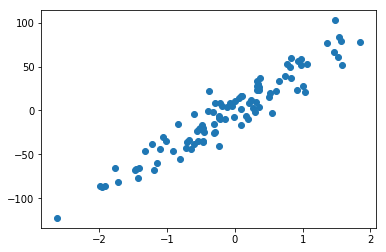

In [0]:
x, y = make_regression(n_samples=100, n_features=1, noise=15, random_state=42)
y = y.reshape(-1, 1)
print(x.shape, y.shape)

plt.scatter(x, y)

Epoch 1/50
100/100 [==============================] - 0s 507us/sample - loss: 1644.8805
Epoch 2/50
100/100 [==============================] - 0s 62us/sample - loss: 988.1741
Epoch 3/50
100/100 [==============================] - 0s 51us/sample - loss: 613.9938
Epoch 4/50
100/100 [==============================] - 0s 52us/sample - loss: 427.3059
Epoch 5/50
100/100 [==============================] - 0s 60us/sample - loss: 326.7776
Epoch 6/50
100/100 [==============================] - 0s 61us/sample - loss: 263.4985
Epoch 7/50
100/100 [==============================] - 0s 72us/sample - loss: 222.2872
Epoch 8/50
100/100 [==============================] - 0s 64us/sample - loss: 206.8904
Epoch 9/50
100/100 [==============================] - 0s 64us/sample - loss: 195.0378
Epoch 10/50
100/100 [==============================] - 0s 65us/sample - loss: 184.7469
Epoch 11/50
100/100 [==============================] - 0s 71us/sample - loss: 177.6408
Epoch 12/50
100/100 [=============================

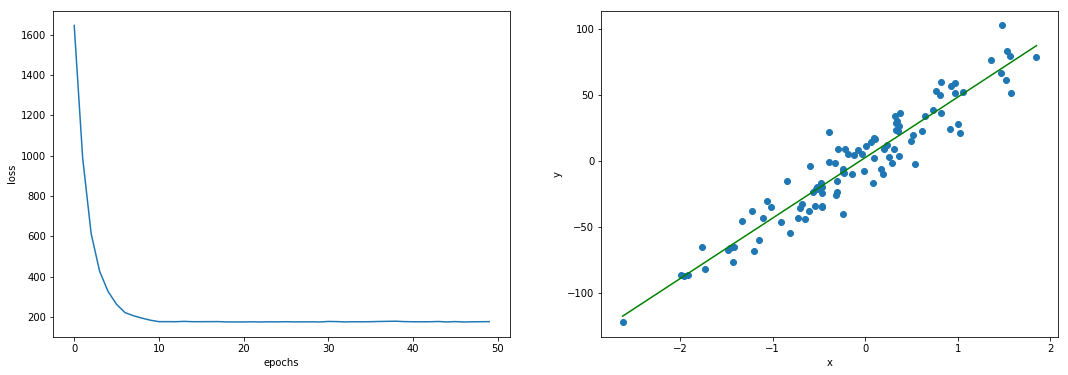

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=1, activation='linear', input_shape=(1, )))

model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.05), loss='mse')

hist = model.fit(x, y, epochs=50)

plot_hist_and_line(hist.history, x, y, model)

## Regressão Quadrática

(100, 1) (100, 1)


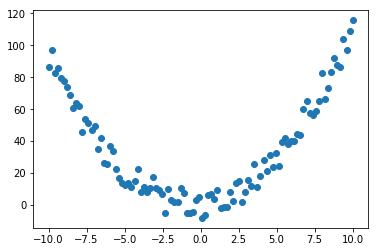

In [0]:
x, y = make_square(n_samples=100, x_min=-10, x_max=10, a=1, b=1, c=1, noise=10)
print(x.shape, y.shape)

plt.scatter(x, y)

minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float32))

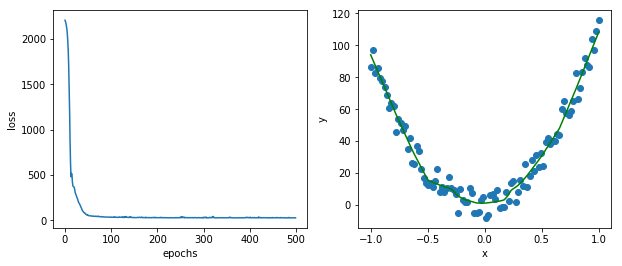

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=100, activation='relu', input_shape=(1, )))
model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='linear'))

model.compile(optimizer='adam', loss='mse')

hist = model.fit(x, y, epochs=500, verbose=0)

plot_hist_and_line(hist.history, x, y, model)

## Regressão Cúbica

(100, 1) (100, 1)


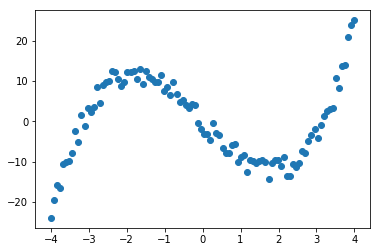

In [0]:
x, y = make_cubic(n_samples=100, x_min=-4, x_max=4, a=1, b=0, c=-10, d=0, noise=3)
print(x.shape, y.shape)

plt.scatter(x, y)

minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

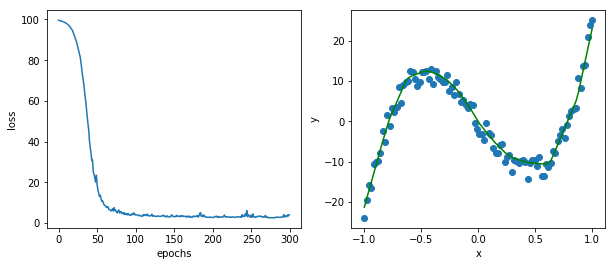

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=100, activation='relu', input_shape=(1, )))
model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='linear'))

model.compile(optimizer='adam', loss='mse')

hist = model.fit(x, y, epochs=300, verbose=0)

plot_hist_and_line(hist.history, x, y, model)

In [0]:
hist.history['loss'][-1]

4.07328010559082

## Regressão Logarítmica

(100, 1) (100, 1)


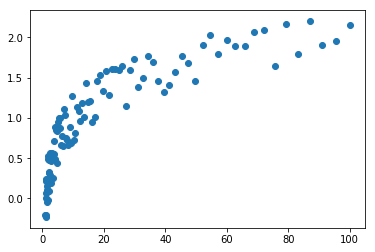

In [0]:
x, y = make_log10(n_samples=100, x_min=1, x_max=100, noise=0.3)
print(x.shape, y.shape)

plt.scatter(x, y)

minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

Epoch 1/200
100/100 [==============================] - 0s 1ms/sample - loss: 1.4284
Epoch 2/200
100/100 [==============================] - 0s 102us/sample - loss: 1.3757
Epoch 3/200
100/100 [==============================] - 0s 93us/sample - loss: 1.3117
Epoch 4/200
100/100 [==============================] - 0s 77us/sample - loss: 1.2510
Epoch 5/200
100/100 [==============================] - 0s 89us/sample - loss: 1.1832
Epoch 6/200
100/100 [==============================] - 0s 88us/sample - loss: 1.1073
Epoch 7/200
100/100 [==============================] - 0s 75us/sample - loss: 1.0138
Epoch 8/200
100/100 [==============================] - 0s 86us/sample - loss: 0.9264
Epoch 9/200
100/100 [==============================] - 0s 74us/sample - loss: 0.8378
Epoch 10/200
100/100 [==============================] - 0s 78us/sample - loss: 0.7692
Epoch 11/200
100/100 [==============================] - 0s 68us/sample - loss: 0.6974
Epoch 12/200
100/100 [==============================] - 0s 79us

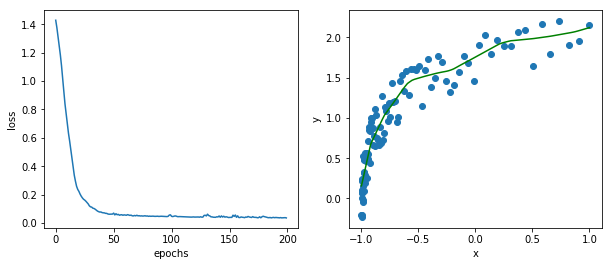

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=100, activation='relu', input_shape=(1, )))
model.add(tf.keras.layers.Dense(units=50, activation='relu'))
model.add(tf.keras.layers.Dense(units=25, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='relu'))
model.add(tf.keras.layers.Dense(units=5, activation='relu'))
model.add(tf.keras.layers.Dense(units=2, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='linear'))

model.compile(optimizer='adam', loss='mse')

hist = model.fit(x, y, epochs=200, verbose=1)

plot_hist_and_line(hist.history, x, y, model)

## Regressão Exponencial

(100, 1) (100, 1)


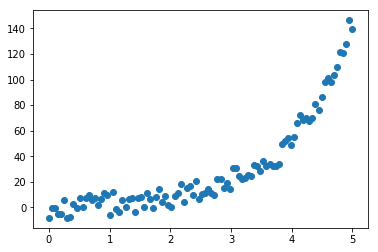

In [0]:
x, y = make_exp(n_samples=100, x_min=0, x_max=5, noise=10)
print(x.shape, y.shape)

plt.scatter(x, y)

minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

Epoch 1/700
100/100 [==============================] - 0s 1ms/sample - loss: 2204.5043
Epoch 2/700
100/100 [==============================] - 0s 137us/sample - loss: 2191.1424
Epoch 3/700
100/100 [==============================] - 0s 128us/sample - loss: 2173.9137
Epoch 4/700
100/100 [==============================] - 0s 138us/sample - loss: 2140.2098
Epoch 5/700
100/100 [==============================] - 0s 127us/sample - loss: 2085.3495
Epoch 6/700
100/100 [==============================] - 0s 598us/sample - loss: 1995.7073
Epoch 7/700
100/100 [==============================] - 0s 137us/sample - loss: 1843.2915
Epoch 8/700
100/100 [==============================] - 0s 121us/sample - loss: 1612.2168
Epoch 9/700
100/100 [==============================] - 0s 152us/sample - loss: 1309.0059
Epoch 10/700
100/100 [==============================] - 0s 127us/sample - loss: 870.3740
Epoch 11/700
100/100 [==============================] - 0s 130us/sample - loss: 422.6537
Epoch 12/700
100/100 [=

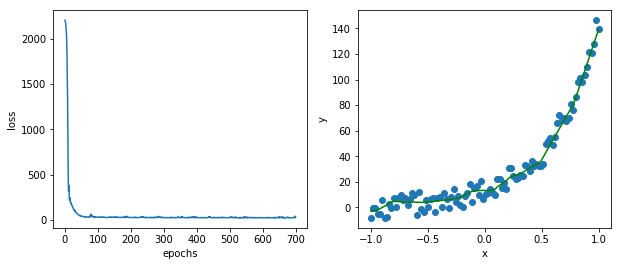

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=100, activation='relu', input_shape=(1, )))
model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='linear'))

model.compile(optimizer='adam', loss='mse')

hist = model.fit(x, y, epochs=700, verbose=1)

plot_hist_and_line(hist.history, x, y, model)

# Classificação Binária

## Blobs

(100, 2) (100, 1)


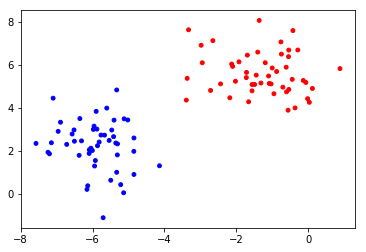

In [0]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Epoch 1/100
100/100 [==============================] - 0s 884us/sample - loss: 0.4782 - accuracy: 0.6900
Epoch 2/100
100/100 [==============================] - 0s 90us/sample - loss: 0.4707 - accuracy: 0.7100
Epoch 3/100
100/100 [==============================] - 0s 113us/sample - loss: 0.4636 - accuracy: 0.7300
Epoch 4/100
100/100 [==============================] - 0s 90us/sample - loss: 0.4576 - accuracy: 0.7400
Epoch 5/100
100/100 [==============================] - 0s 102us/sample - loss: 0.4513 - accuracy: 0.7600
Epoch 6/100
100/100 [==============================] - 0s 105us/sample - loss: 0.4464 - accuracy: 0.8000
Epoch 7/100
100/100 [==============================] - 0s 106us/sample - loss: 0.4420 - accuracy: 0.8100
Epoch 8/100
100/100 [==============================] - 0s 115us/sample - loss: 0.4380 - accuracy: 0.8200
Epoch 9/100
100/100 [==============================] - 0s 91us/sample - loss: 0.4340 - accuracy: 0.8500
Epoch 10/100
100/100 [==============================] - 0s

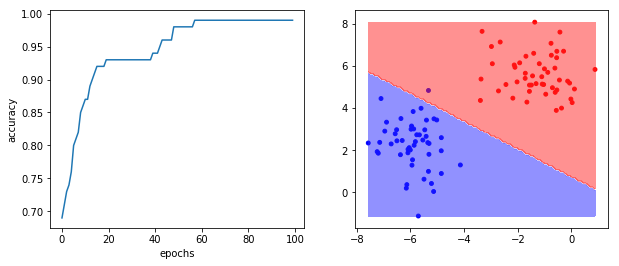

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=1, activation='relu', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

hist = model.fit(x, y, batch_size=16, epochs=100, verbose=1)

plot_hist_and_predictions(hist.history, x, y, model, cmap='bwr')

## 4 Clusters

(500, 2) (500, 1)


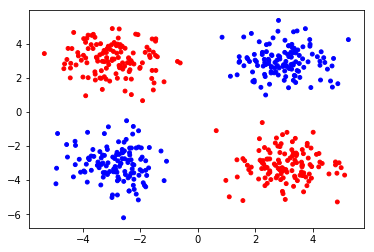

In [0]:
x, y = make_blobs(n_samples=500, n_features=2, cluster_std=0.9, centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], random_state=1234)
y = y.reshape(-1, 1)
y = np.where(y >= 2, 1, 0)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Epoch 1/150
500/500 [==============================] - 0s 219us/sample - loss: 0.7439 - accuracy: 0.4900
Epoch 2/150
500/500 [==============================] - 0s 38us/sample - loss: 0.6550 - accuracy: 0.5020
Epoch 3/150
500/500 [==============================] - 0s 38us/sample - loss: 0.5778 - accuracy: 0.6160
Epoch 4/150
500/500 [==============================] - 0s 38us/sample - loss: 0.5120 - accuracy: 0.8040
Epoch 5/150
500/500 [==============================] - 0s 35us/sample - loss: 0.4560 - accuracy: 0.8840
Epoch 6/150
500/500 [==============================] - 0s 37us/sample - loss: 0.4072 - accuracy: 0.9300
Epoch 7/150
500/500 [==============================] - 0s 37us/sample - loss: 0.3664 - accuracy: 0.9620
Epoch 8/150
500/500 [==============================] - 0s 39us/sample - loss: 0.3315 - accuracy: 0.9920
Epoch 9/150
500/500 [==============================] - 0s 37us/sample - loss: 0.3010 - accuracy: 0.9940
Epoch 10/150
500/500 [==============================] - 0s 35us

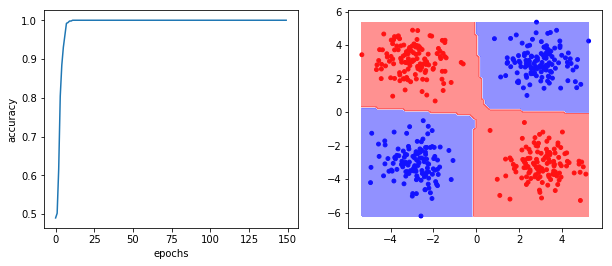

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=10, activation='relu', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid', ))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

hist = model.fit(x, y, batch_size=32, epochs=150, verbose=1)

plot_hist_and_predictions(hist.history, x, y, model, cmap='bwr')

## Círculos

(500, 2) (500, 1)


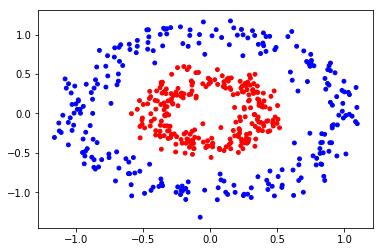

In [0]:
x, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
500/500 [==============================] - 0s 167us/sample - loss: 0.7938 - accuracy: 0.4960
Epoch 2/150
500/500 [==============================] - 0s 37us/sample - loss: 0.7918 - accuracy: 0.4960
Epoch 3/150
500/500 [==============================] - 0s 35us/sample - loss: 0.7897 - accuracy: 0.4960
Epoch 4/150
500/500 [==============================] - 0s 35us/sample - loss: 0.7877 - accuracy: 0.4960
Epoch 5/150
500/500 [==============================] - 0s 35us/sample - loss: 0.7856 - accuracy: 0.4960
Epoch 6/150
500/500 [==============================] - 0s 32us/sample - loss: 0.7838 - accuracy: 0.4960
Epoch 7/150
500/500 [=======

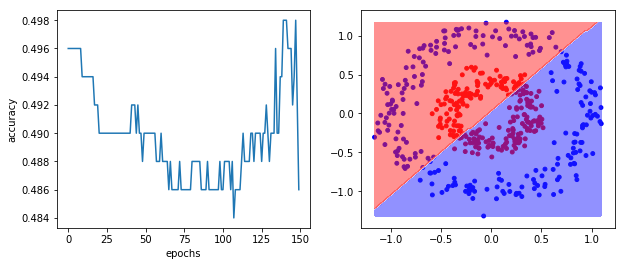

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid', input_shape=(2, )))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

hist = model.fit(x, y, batch_size=32, epochs=150, verbose=1)

plot_hist_and_predictions(hist.history, x, y, model, cmap='bwr')

## Moons

(200, 2) (200, 1)


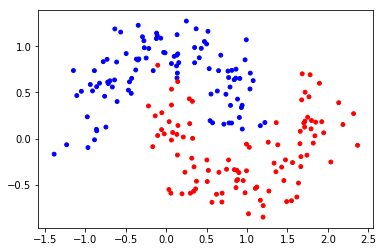

In [0]:
x, y = make_moons(200, noise=0.20)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Epoch 1/350
200/200 [==============================] - 0s 754us/sample - loss: 0.6290 - accuracy: 0.8100
Epoch 2/350
200/200 [==============================] - 0s 112us/sample - loss: 0.4323 - accuracy: 0.8500
Epoch 3/350
200/200 [==============================] - 0s 119us/sample - loss: 0.2877 - accuracy: 0.8600
Epoch 4/350
200/200 [==============================] - 0s 107us/sample - loss: 0.2871 - accuracy: 0.8550
Epoch 5/350
200/200 [==============================] - 0s 112us/sample - loss: 0.2741 - accuracy: 0.8550
Epoch 6/350
200/200 [==============================] - 0s 104us/sample - loss: 0.2544 - accuracy: 0.8850
Epoch 7/350
200/200 [==============================] - 0s 105us/sample - loss: 0.2325 - accuracy: 0.8950
Epoch 8/350
200/200 [==============================] - 0s 108us/sample - loss: 0.2217 - accuracy: 0.8950
Epoch 9/350
200/200 [==============================] - 0s 100us/sample - loss: 0.2089 - accuracy: 0.9050
Epoch 10/350
200/200 [==============================] -

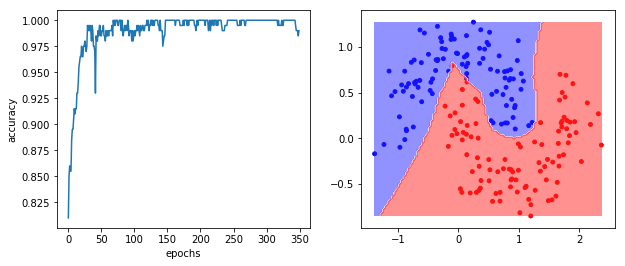

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=170, activation='relu', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=190, activation='relu'))
model.add(tf.keras.layers.Dense(units=190, activation='relu'))
model.add(tf.keras.layers.Dense(units=190, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

hist = model.fit(x, y, batch_size=32, epochs=350, verbose=1)

plot_hist_and_predictions(hist.history, x, y, model, cmap='bwr')

## Espiral

(200, 2) (200, 1)


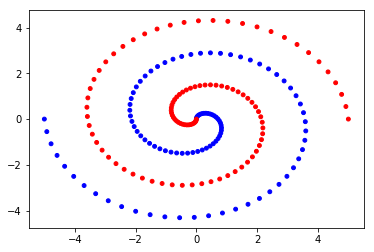

In [0]:
x, y = make_spiral(n_samples=100, n_class=2, radius=5, laps=1.75)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_77 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_78 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_79 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_80 (Dense)             (None, 1)                 101       
Total params: 30,701
Trainable params: 30,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
200/200 [==============================] - 0s 549us/sample - loss: 0.7518 - accuracy: 0.4650
Epoch 2/50

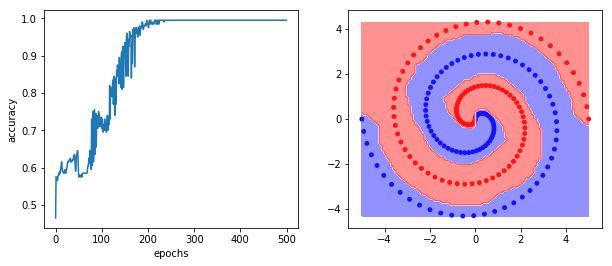

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=100, activation='tanh', input_shape=(2,)))
model.add(tf.keras.layers.Dense(units=100, activation='tanh'))
model.add(tf.keras.layers.Dense(units=100, activation='tanh'))
model.add(tf.keras.layers.Dense(units=100, activation='tanh'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

hist = model.fit(x, y, batch_size=200, epochs=500)

plot_hist_and_predictions(hist.history, x, y, model, cmap='bwr')

# Classificação Multiclasse

## 3 Clusters

(300, 2) (300, 1)


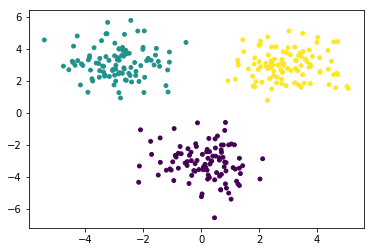

In [0]:
x, y = make_blobs(n_samples=300, n_features=2, centers=[(0, -3), (-3, 3), (3, 3)], random_state=1234)
y = y.reshape(-1, 1)
print(x.shape, y.shape)

plt.scatter(x[:, 0], x[:, 1], c=y.flatten(), s=15)

Epoch 1/50
300/300 [==============================] - 0s 223us/sample - loss: 1.6654 - accuracy: 0.3133
Epoch 2/50
300/300 [==============================] - 0s 40us/sample - loss: 1.5003 - accuracy: 0.3200
Epoch 3/50
300/300 [==============================] - 0s 47us/sample - loss: 1.3499 - accuracy: 0.3300
Epoch 4/50
300/300 [==============================] - 0s 47us/sample - loss: 1.2041 - accuracy: 0.3567
Epoch 5/50
300/300 [==============================] - 0s 44us/sample - loss: 1.0719 - accuracy: 0.3900
Epoch 6/50
300/300 [==============================] - 0s 43us/sample - loss: 0.9512 - accuracy: 0.4600
Epoch 7/50
300/300 [==============================] - 0s 40us/sample - loss: 0.8458 - accuracy: 0.5700
Epoch 8/50
300/300 [==============================] - 0s 43us/sample - loss: 0.7524 - accuracy: 0.6433
Epoch 9/50
300/300 [==============================] - 0s 41us/sample - loss: 0.6707 - accuracy: 0.7067
Epoch 10/50
300/300 [==============================] - 0s 40us/sample - 

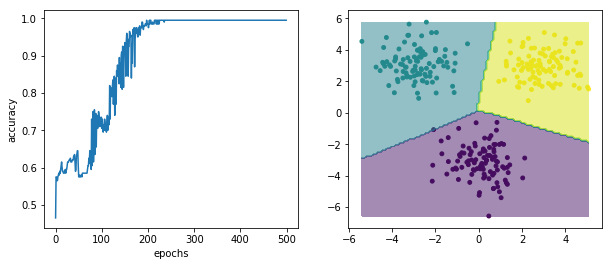

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=10, activation='relu', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=3, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(x, y, batch_size=32, epochs=50, verbose=1)

plot_hist_and_predictions(hist.history, x, y, model)

## 4 Clusters

(400, 2) (400, 1)


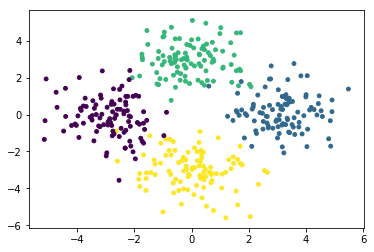

In [0]:
x, y = make_blobs(n_samples=400, n_features=2, centers=[(-3, 0), (3, 0), (0, 3), (0, -3)], random_state=1234)
y = y.reshape(-1, 1)
print(x.shape, y.shape)

plt.scatter(x[:, 0], x[:, 1], c=y.flatten(), s=15)

Epoch 1/50
400/400 [==============================] - 0s 175us/sample - loss: 2.3871 - accuracy: 0.1900
Epoch 2/50
400/400 [==============================] - 0s 39us/sample - loss: 2.2265 - accuracy: 0.2400
Epoch 3/50
400/400 [==============================] - 0s 38us/sample - loss: 2.0851 - accuracy: 0.2625
Epoch 4/50
400/400 [==============================] - 0s 37us/sample - loss: 1.9591 - accuracy: 0.2825
Epoch 5/50
400/400 [==============================] - 0s 38us/sample - loss: 1.8456 - accuracy: 0.2975
Epoch 6/50
400/400 [==============================] - 0s 38us/sample - loss: 1.7466 - accuracy: 0.3250
Epoch 7/50
400/400 [==============================] - 0s 39us/sample - loss: 1.6542 - accuracy: 0.3950
Epoch 8/50
400/400 [==============================] - 0s 38us/sample - loss: 1.5714 - accuracy: 0.4950
Epoch 9/50
400/400 [==============================] - 0s 35us/sample - loss: 1.4919 - accuracy: 0.5525
Epoch 10/50
400/400 [==============================] - 0s 37us/sample - 

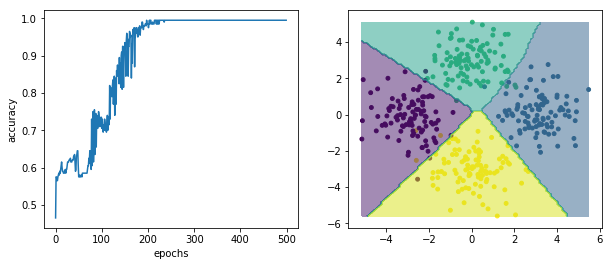

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=10, activation='relu', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=4, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(x, y, batch_size=32, epochs=50, verbose=1)

plot_hist_and_predictions(hist.history, x, y, model)

## Espiral - 5 Classes

(500, 2) (500, 1)


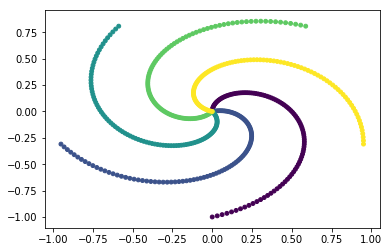

In [0]:
x, y = make_spiral(n_samples=100, n_class=5, radius=1, laps=0.5)
y = y.reshape(-1, 1)
print(x.shape, y.shape)

plt.scatter(x[:, 0], x[:, 1], c=y.flatten(), s=15)

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_101 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_102 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_103 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_104 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_105 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_106 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_107 (Dense)            (None, 5)               

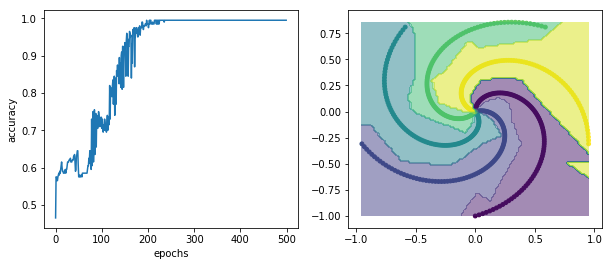

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=10, activation='relu', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=10, activation='linear'))
model.add(tf.keras.layers.Dense(units=10, activation='linear'))
model.add(tf.keras.layers.Dense(units=10, activation='linear'))
model.add(tf.keras.layers.Dense(units=10, activation='linear'))
model.add(tf.keras.layers.Dense(units=10, activation='linear'))
model.add(tf.keras.layers.Dense(units=5, activation='softmax'))
model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(x, y, batch_size=100, epochs=400, verbose=1)

plot_hist_and_predictions(hist.history, x, y, model)

## Make Classification - 4 Classes

(100, 2) (100, 1)


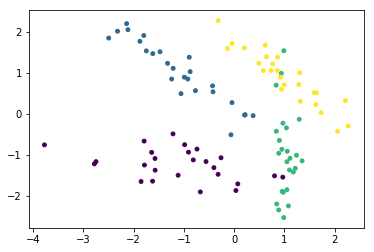

In [0]:
x, y = make_classification(n_samples=100, n_classes=4, n_features=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, random_state=1234)
y = y.reshape(-1, 1)
print(x.shape, y.shape)

plt.scatter(x[:, 0], x[:, 1], c=y.flatten(), s=15)

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_111 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_112 (Dense)            (None, 8)                 88        
_________________________________________________________________
dense_113 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_114 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_115 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_116 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_117 (Dense)            (None, 4)               

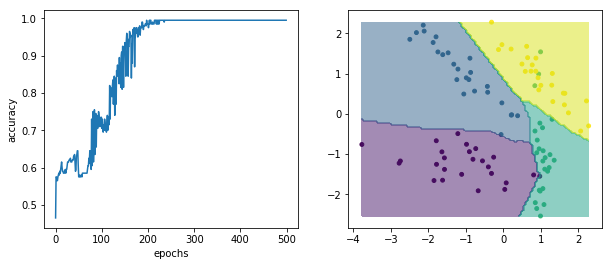

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=10, activation='relu', input_shape=(2, )))
model.add(tf.keras.layers.Dense(units=8, activation='linear'))
model.add(tf.keras.layers.Dense(units=8, activation='linear'))
model.add(tf.keras.layers.Dense(units=8, activation='linear'))
model.add(tf.keras.layers.Dense(units=8, activation='linear'))
model.add(tf.keras.layers.Dense(units=8, activation='linear'))
model.add(tf.keras.layers.Dense(units=4, activation='softmax'))
model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(x, y, batch_size=100, epochs=500, verbose=1)

plot_hist_and_predictions(hist.history, x, y, model)

## MNIST - 10 classes

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


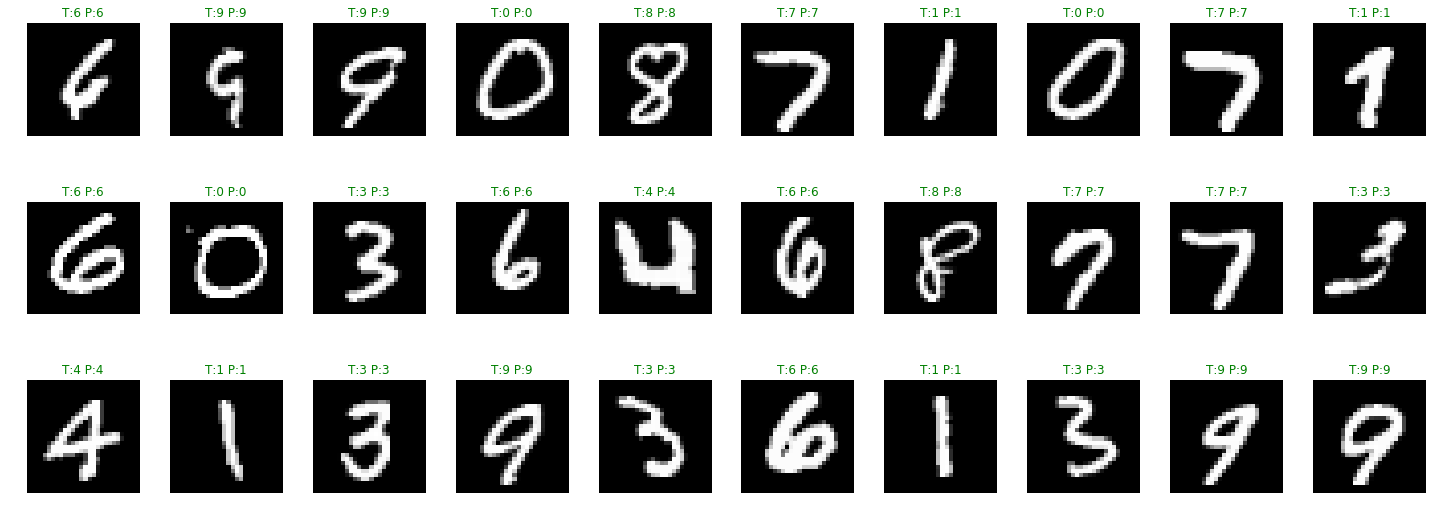

In [0]:
plot_random_batch(x_train, y_train)

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model.add(tf.keras.layers.Dense(units=200, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

for layer in model.layers[:-1]:
    layer.trainable = False

model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

list_callbacks = [
    ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', verbose=1, mode='max', save_best_only=True),
    EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, mode='max', restore_best_weights=True)
]

# hist = model.fit(x_train / 255, y_train, 
#                  batch_size=128, 
#                  epochs=100, 
#                  validation_data=(x_test, y_test), 
#                  callbacks=list_callbacks)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 200)               157000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 10)                2010      
Total params: 159,010
Trainable params: 2,010
Non-trainable params: 157,000
_________________________________________________________________


In [0]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 66us/sample - loss: 11.1646 - accuracy: 0.9799


[11.16456227998212, 0.9799]

In [0]:
model.save('best_model_ever.hdf5')

In [0]:
model = tf.keras.models.load_model('best_model_ever.hdf5')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 200)               157000    
_________________________________________________________________
dense_9 (Dense)              (None, 10)                2010      
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
_________________________________________________________________


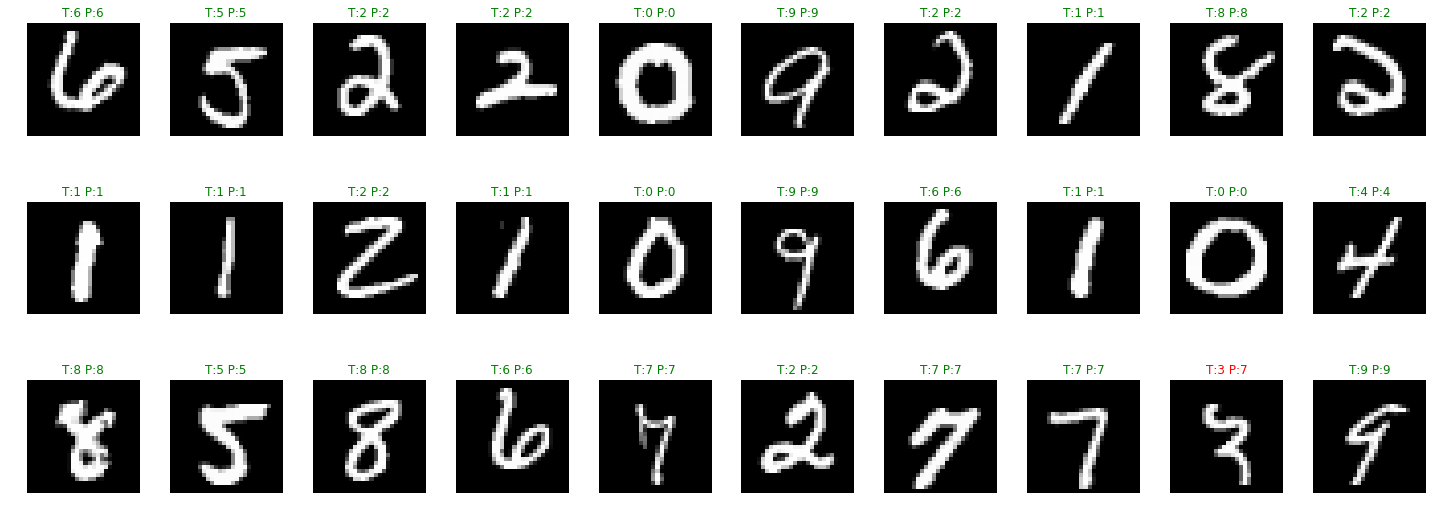

In [0]:
y_pred = model.predict_classes(x_test / 255)

plot_random_batch(x_test, y_test, y_pred)

# Rede Convolucional

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = np.expand_dims(x_train, axis=-1), np.expand_dims(x_test, axis=-1)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)


In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=20, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))
model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
x_train / 255, y_train
model.fit(, batch_size=32, epochs=1, validation_split=0.3)
model.evaluate(x_test / 255, y_test)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 16)        1168      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                15700     
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

[0.09151925478652119, 0.9703]

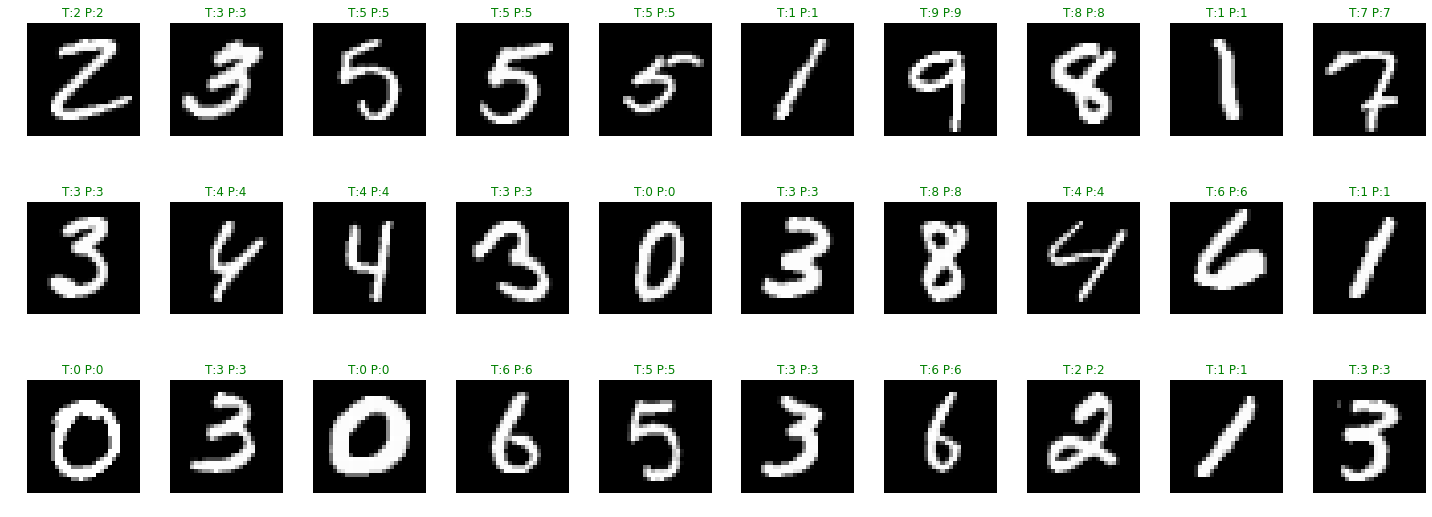

In [0]:
y_pred = model.predict_classes(x_test / 255)

plot_random_batch(x_test, y_test, y_pred)